## nn.AdaptiveAvgPool2d((1, 1))

- nn.AdaptiveAvgPool2d((1, 1))는 PyTorch에서 입력 feature map의 크기에 상관없이 항상 (1, 1) 크기의 출력을 만들어주는 평균 풀링 계층

- CNN의 마지막에 붙여서, 각 채널마다 평균값 1개만 남기고 완전 연결층(nn.Linear)에 넣기 좋게 만든다.

In [37]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

In [38]:
# ============================
# 1. CNN 모델 정의
# ============================
'''
class MNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),  # (1, 28, 28) → (16, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(2),                 # (16, 14, 14)
            nn.Conv2d(16, 32, 3, padding=1), # (32, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(2),                 # (32, 7, 7)
            nn.AdaptiveAvgPool2d((1, 1))     # (32, 1, 1)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),                    # (32, 1, 1) → (32)
            nn.Linear(32, 10)                # Output: 10 classes
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
'''

'\nclass MNIST_CNN(nn.Module):\n    def __init__(self):\n        super().__init__()\n        self.features = nn.Sequential(\n            nn.Conv2d(1, 16, 3, padding=1),  # (1, 28, 28) → (16, 28, 28)\n            nn.ReLU(),\n            nn.MaxPool2d(2),                 # (16, 14, 14)\n            nn.Conv2d(16, 32, 3, padding=1), # (32, 14, 14)\n            nn.ReLU(),\n            nn.MaxPool2d(2),                 # (32, 7, 7)\n            nn.AdaptiveAvgPool2d((1, 1))     # (32, 1, 1)\n        )\n        self.classifier = nn.Sequential(\n            nn.Flatten(),                    # (32, 1, 1) → (32)\n            nn.Linear(32, 10)                # Output: 10 classes\n        )\n\n    def forward(self, x):\n        x = self.features(x)\n        x = self.classifier(x)\n        return x\n'

In [39]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),   # (1, 28, 28) → (16, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(2),                  # (16, 14, 14)

            nn.Conv2d(16, 32, 3, padding=1),  # (32, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(2)                   # (32, 7, 7)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),                    # (32, 7, 7) → (1568)
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [40]:
#  Data transform (with augmentation)
trans = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor()
])

In [41]:
# ============================
# 2. 데이터셋 로드
# ============================
train_data = torchvision.datasets.MNIST("./data/", train=True, download=True, transform=trans)
val_data = torchvision.datasets.MNIST("./data/", train=False, download=True, transform=trans)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

In [42]:
train_N = len(train_data)
valid_N = len(val_data)
print(f"train_N: {train_N}, valid_N: {valid_N}")

train_N: 60000, valid_N: 10000


In [43]:
# ============================
# 3. 모델, 손실 함수, 옵티마이저
# ============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MNIST_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [44]:
# ============================
# 4. 학습 루프
# ============================
num_epochs = 20
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / train_N)
    train_accuracies.append(100 * correct / train_N)

    # ---------- 검증 ----------
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / valid_N)
    val_accuracies.append(100 * correct / valid_N)

    print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Acc = {train_accuracies[-1]:.2f}%, "
          f"Val Loss = {val_losses[-1]:.4f}, Acc = {val_accuracies[-1]:.2f}%")


Epoch 1: Train Loss = 0.4544, Acc = 85.39%, Val Loss = 0.1420, Acc = 95.45%
Epoch 2: Train Loss = 0.1651, Acc = 94.89%, Val Loss = 0.0909, Acc = 96.91%
Epoch 3: Train Loss = 0.1262, Acc = 96.16%, Val Loss = 0.0683, Acc = 97.59%
Epoch 4: Train Loss = 0.1063, Acc = 96.72%, Val Loss = 0.0574, Acc = 98.18%
Epoch 5: Train Loss = 0.0937, Acc = 97.16%, Val Loss = 0.0499, Acc = 98.40%
Epoch 6: Train Loss = 0.0863, Acc = 97.41%, Val Loss = 0.0449, Acc = 98.50%
Epoch 7: Train Loss = 0.0815, Acc = 97.57%, Val Loss = 0.0437, Acc = 98.70%
Epoch 8: Train Loss = 0.0738, Acc = 97.72%, Val Loss = 0.0493, Acc = 98.40%
Epoch 9: Train Loss = 0.0669, Acc = 97.94%, Val Loss = 0.0408, Acc = 98.78%
Epoch 10: Train Loss = 0.0656, Acc = 97.99%, Val Loss = 0.0360, Acc = 98.81%
Epoch 11: Train Loss = 0.0606, Acc = 98.20%, Val Loss = 0.0396, Acc = 98.75%
Epoch 12: Train Loss = 0.0599, Acc = 98.12%, Val Loss = 0.0398, Acc = 98.83%
Epoch 13: Train Loss = 0.0577, Acc = 98.24%, Val Loss = 0.0336, Acc = 98.86%
Epoch 14

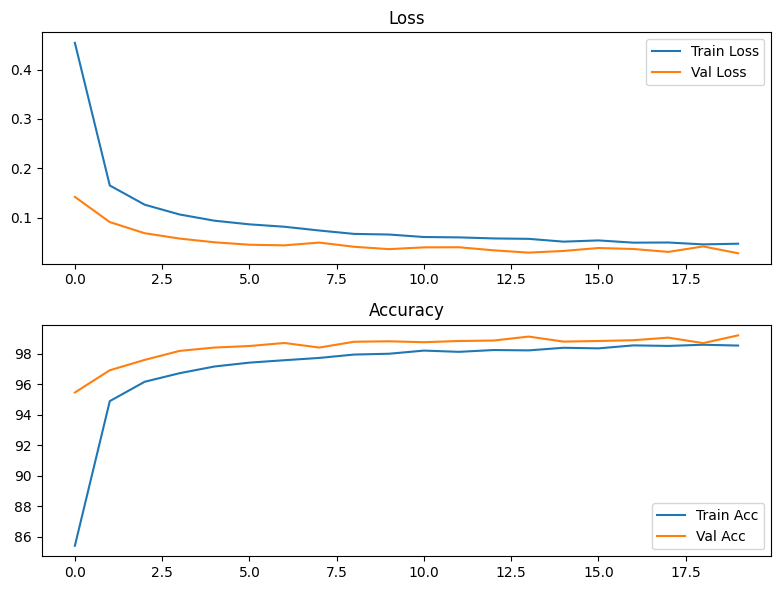

In [47]:
fig = plt.subplots(2, 1, figsize=(8, 6))

# Loss
plt.subplot(2, 1, 1)  # 2행 1열 중 첫 번째 위치
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss")
plt.legend()

# Accuracy
plt.subplot(2, 1, 2)  # 2행 1열 중 두 번째 위치
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.tight_layout()
plt.savefig("adaptive_training_results.png")
plt.show()

In [46]:
torch.save(model.state_dict(), "model/model_adaptive.pth")
print("모델 저장 완료: model_adaptive.pth")

RuntimeError: Parent directory model does not exist.

In [ ]:
model.load_state_dict(torch.load("model/model_adaptive.pth", map_location=device))
model.eval()

In [ ]:
from PIL import Image, ImageOps

In [ ]:
# 1. 입력 이미지 전처리 (예: 'sample_digit.png' 파일)
img = Image.open("test_data/digit_5_label_2.png").convert("L")      # 흑백으로 변환
# img = ImageOps.invert(img)                             # MNIST 스타일 반전 (흰 배경, 검은 숫자)
img = img.resize((28, 28))                             # 28x28 리사이즈

# 2. 이미지 출력
plt.imshow(img, cmap='gray')       # 흑백으로 표시
plt.title("Processed MNIST-style Digit")
plt.axis("off")                    # 축 제거
plt.show()

In [ ]:
transform = transforms.ToTensor()
input_tensor = transform(img).unsqueeze(0).to(device)  # shape: (1, 1, 28, 28)

In [ ]:
# 2. 추론
with torch.no_grad():
    output = model(input_tensor)
    pred = torch.argmax(output, dim=1).item()
    confidence = torch.softmax(output, dim=1).squeeze()[pred].item()

# 3. 출력
print(f"예측 숫자: {pred}")
print(f"신뢰도: {confidence * 100:.2f}%")